In [1]:
from RSoftSimulation import RSoftSim
from Circuit_Properties import *
from Functions import *
from HexProperties import *

simulation_val = {
    "launch_type": LaunchType.MM,
    "monitor_type": Monitor_Prop.FIBRE_MODE_POWER,
    "comp": Monitor_comp.MAJOR,
    "launch_tilt": 0,
    "launch_mode": '*',
    "launch_mode_radial": '*',
    "launch_random_set": 1,
    "num_paras": 36,
    "batch_num": 6,
}

with open("launch_config.json", "w") as launch_config:
    json.dump(simulation_val, launch_config, indent = 2)

# setup custom priors
custom_priors = {
            "Taper_L": (1000.0, 60000.0),
            "taper": (1, 30) 
            }

sim = RSoftSim()
sim.init_priors(custom_priors)
sim.RunRSoft(True)


UnboundLocalError: cannot access local variable 'params' where it is not associated with a value

Best fitting values:
Taper_L: 29970.758
taper: 17.130
Throughput: 0.970


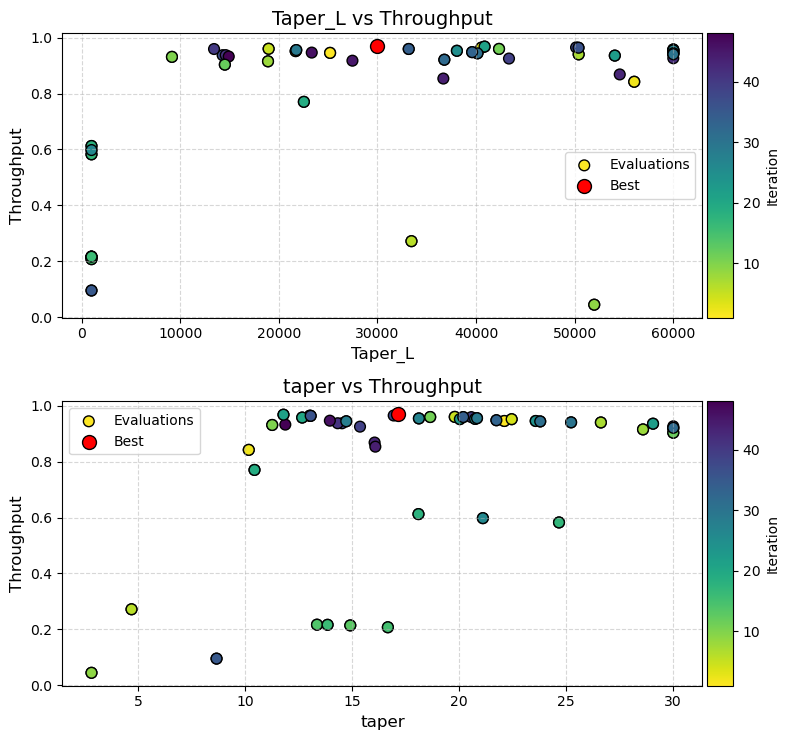

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("optimizer_results.csv")

param_names = list(custom_priors.keys())

plotting_optimizer_results(data, param_names)